In [7]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
n_dim = 2

# 2차원 벡터 생성
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [3]:
def label_map(y_, from_, to_): 
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

In [4]:
# label이 0 또는 1 -> 0 , label이 2 또는 3 -> 1
y_train = label_map(y_train, [0,1], 0)
y_train = label_map(y_train, [2,3], 1)
y_test = label_map(y_test, [0,1], 0)
y_test = label_map(y_test, [2,3], 1)

In [5]:
# 데이터를 시각화하는 함수
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None]*len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

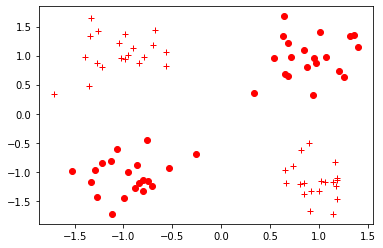

In [8]:
plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [9]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [16]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size) # wx+b 연산 객체
        self.relu = torch.nn.ReLU() # 활성화 함수
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid() # 활성화 함수
    
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor) # input_tensor에 input_size x hidden_size 크기의 w를 곱하고 b를 더함
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2) # sigmoid => 0~1 사이의 output 값 도출
        return output

In [17]:
model = NeuralNet(2, 5) # 신경망 객체 생성
learning_rate = 0.03
criterion = torch.nn.BCELoss() # 오차함수 : 이진 교차 엔트로피
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # 최적화 알고리즘 : 확률적 경사하강법

In [18]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item())) # 학습 전 오차 출력

Before Training, test loss is 0.6910572648048401


In [19]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    train_output = model(x_train)
    
    train_loss = criterion(train_output.squeeze(), y_train)
    
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item())) # 학습하면서 오차 출력
        
    # back propagation
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.6900791525840759
Train loss at 100 is 0.6481741666793823
Train loss at 200 is 0.5847550630569458
Train loss at 300 is 0.5037289261817932
Train loss at 400 is 0.4195772111415863
Train loss at 500 is 0.331360399723053
Train loss at 600 is 0.25907790660858154
Train loss at 700 is 0.20242789387702942
Train loss at 800 is 0.1580849587917328
Train loss at 900 is 0.12305837869644165
Train loss at 1000 is 0.09623271226882935
Train loss at 1100 is 0.07647708058357239
Train loss at 1200 is 0.062319833785295486
Train loss at 1300 is 0.05203288048505783
Train loss at 1400 is 0.044394057244062424
Train loss at 1500 is 0.03852638602256775
Train loss at 1600 is 0.03390992060303688
Train loss at 1700 is 0.0302019901573658
Train loss at 1800 is 0.027167221531271935
Train loss at 1900 is 0.024650610983371735


In [21]:
model.eval()
test_loss_before = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss_before.item())) # 학습 후 오차 출력

After Training, test loss is 0.023906800895929337


In [22]:
# 학습된 모델을 .pt 파일로 저장
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.6387,  1.0701],
        [ 1.2773, -1.6860],
        [-1.1483,  0.7536],
        [-1.6104, -1.4496],
        [ 0.8046,  0.9861]])), ('linear_1.bias', tensor([-0.0751,  0.1018, -0.0562, -0.1509,  0.4828])), ('linear_2.weight', tensor([[ 1.8338,  1.9166,  1.3305, -2.0395, -1.3322]])), ('linear_2.bias', tensor([-1.1824]))])


In [23]:
# 새로운 모델을 만들고 학습된 모델을 불러와 학습된 가중치를 입력
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [28]:
new_model.eval()
print('벡터 [-1,1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1,1]이 레이블 1을 가질 확률은 0.9945001602172852
